# META STOCK PRICE PREDICTION USING LSTM 

Name: Alena Maria Thomas

### 1. Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

### 2. Getting the data

We get the stock data for META from the Yahoo Finance website from years starting from year 2012 till present.

This data can be obtained in two ways:
- from the website directly https://finance.yahoo.com/quote/META/history
- using the yfinance library in python

The first method is used here to obtain the dataset.

In [3]:
df = pd.read_csv('META.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.189480,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,33.993931,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,30.967144,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,31.966084,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,32.994991,50237200
...,...,...,...,...,...,...,...
2984,2024-04-01,487.200012,497.429993,481.779999,491.350006,491.350006,9247000
2985,2024-04-02,485.100006,497.529999,484.649994,497.369995,497.369995,11081000
2986,2024-04-03,498.929993,507.239990,498.750000,506.739990,506.739990,12099200
2987,2024-04-04,516.419983,530.000000,510.579987,510.920013,510.920013,26476300


### 3. EDA

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2989.0,1.640720e+02,9.994588e+01,1.808000e+01,8.182000e+01,1.585100e+02,2.104700e+02,5.168600e+02
High,2989.0,1.662084e+02,1.012449e+02,1.827000e+01,8.260000e+01,1.613100e+02,2.134900e+02,5.307000e+02
Low,2989.0,1.620275e+02,9.877781e+01,1.755000e+01,8.124000e+01,1.559700e+02,2.084400e+02,5.144100e+02
Close,2989.0,1.641628e+02,1.000425e+02,1.773000e+01,8.191000e+01,1.588500e+02,2.111300e+02,5.273400e+02
Adj Close,2989.0,1.639945e+02,9.995517e+01,1.771121e+01,8.182319e+01,1.586816e+02,2.109062e+02,5.273400e+02
Volume,2989.0,3.032067e+07,2.618933e+07,5.467500e+06,1.618790e+07,2.255700e+07,3.474720e+07,5.735764e+08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2989 non-null   object 
 1   Open       2989 non-null   float64
 2   High       2989 non-null   float64
 3   Low        2989 non-null   float64
 4   Close      2989 non-null   float64
 5   Adj Close  2989 non-null   float64
 6   Volume     2989 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 163.6+ KB


### 4. Preprocessing the dataset.

In [6]:
type(df.Date[0])

str

The Date column is a string and not a datetime object. Hence, we  make this conversion.

In [7]:
def str_to_datetime(s):
    l = s.split('-')
    year, month, day = int(l[0]), int(l[1]), int(l[2])
    return datetime.datetime(year=year, month=month, day=day)

df.Date = df.Date.apply(str_to_datetime)

We also make the Data column as the index column since it is unique for each row.

In [8]:
df.index = df.pop('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.189480,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,33.993931,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,30.967144,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,31.966084,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,32.994991,50237200


We visualize the trend of the closing price to observe the value that needs to be predicted.

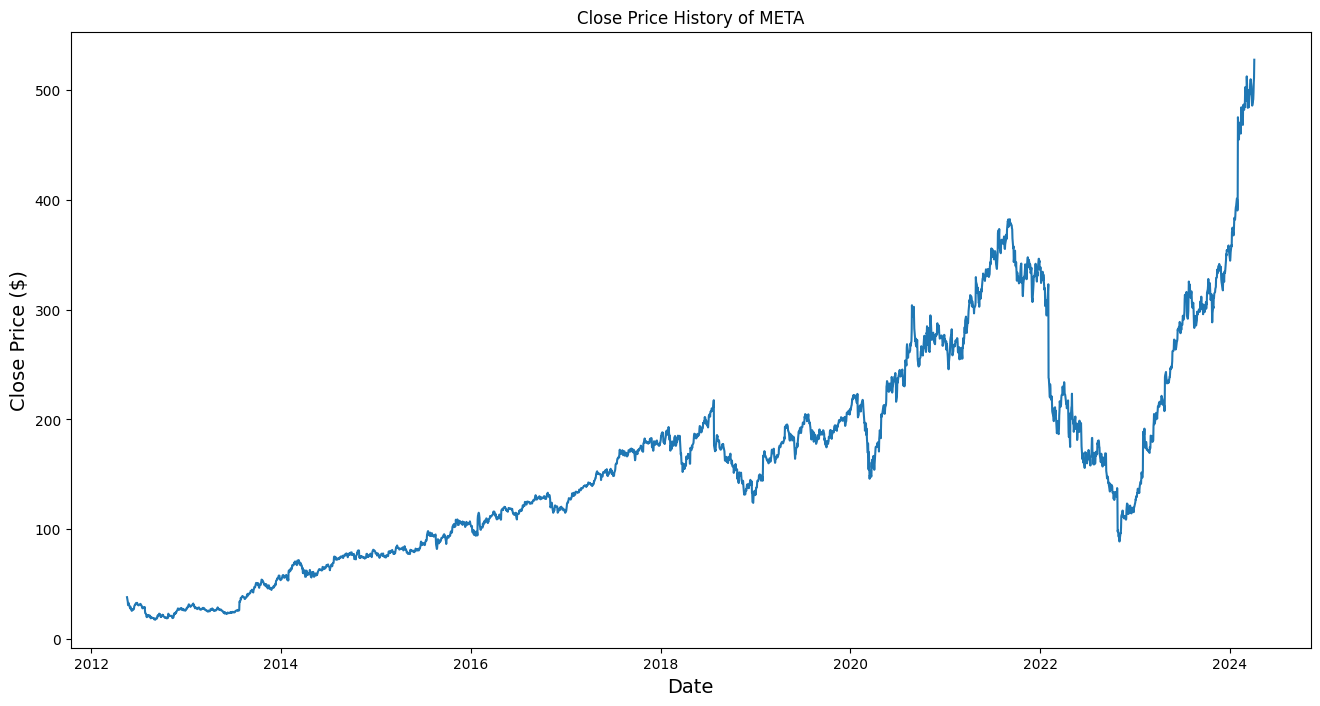

In [9]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of META')
plt.plot(df.Close)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price ($)', fontsize=14)
plt.show()

Lastly, since LSTM model is sensitive to scale, we normalize the 'Close' column using MinMaxScaler().

In [10]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

In [11]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

### 5. Splitting the dataset into training and testing.

We take the first 80% of the dataset to be the training dataset and the remaining 20% as the testing dataset. 

In [12]:
training_data_len = int(len(dataset) * 0.8)
training_data_len

2391

In [13]:
train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

Define the lookback window, which refers to the number of previous time steps used as input features to predict the next time stamp.

In [14]:
lookback = 5

Split the features and label of the training dataset into x_train and y_train based on the 'lookback' value.
- The features are the previous closing values of the stock depending on the value of 'lookback'.
- The label is the closing value on the current date.


In [15]:
x_train, y_train = [], []

for i in range(lookback, len(train_data)):
    x_train.append(train_data[i-lookback:i, 0])
    y_train.append(train_data[i, 0])

In [16]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2386, 5, 1)

### 6. Build and train the LSTM model.

In [18]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(units=1) # Prediction of the next closing value
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\ALENA MARIA THOMAS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0364
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.3762e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9624e-04
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0533e-04
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2750e-04
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4515e-04
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5315e-04
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9621e-04
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9023e-04


### 7. Split the test dataset into x_test and y_test and evaluate the model.

In [21]:
# Creating the x_test and y_test datasets
x_test, y_test = [], []

for i in range(len(test_data)):
    x_test.append(scaled_data[training_data_len+i-lookback : training_data_len+i, 0])
    y_test.append(scaled_data[training_data_len+i, 0])

In [22]:
# Convert to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(598, 5, 1)

In [23]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [24]:
# Get RMSE
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

250.9453906100684

### 8. Visualize the results to assess the model's performance.

We plot the actual and the predicted values of the closing price for the test dataset and compare the result.

C:\Users\ALENA MARIA THOMAS\AppData\Local\Temp\ipykernel_29904\2868077799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


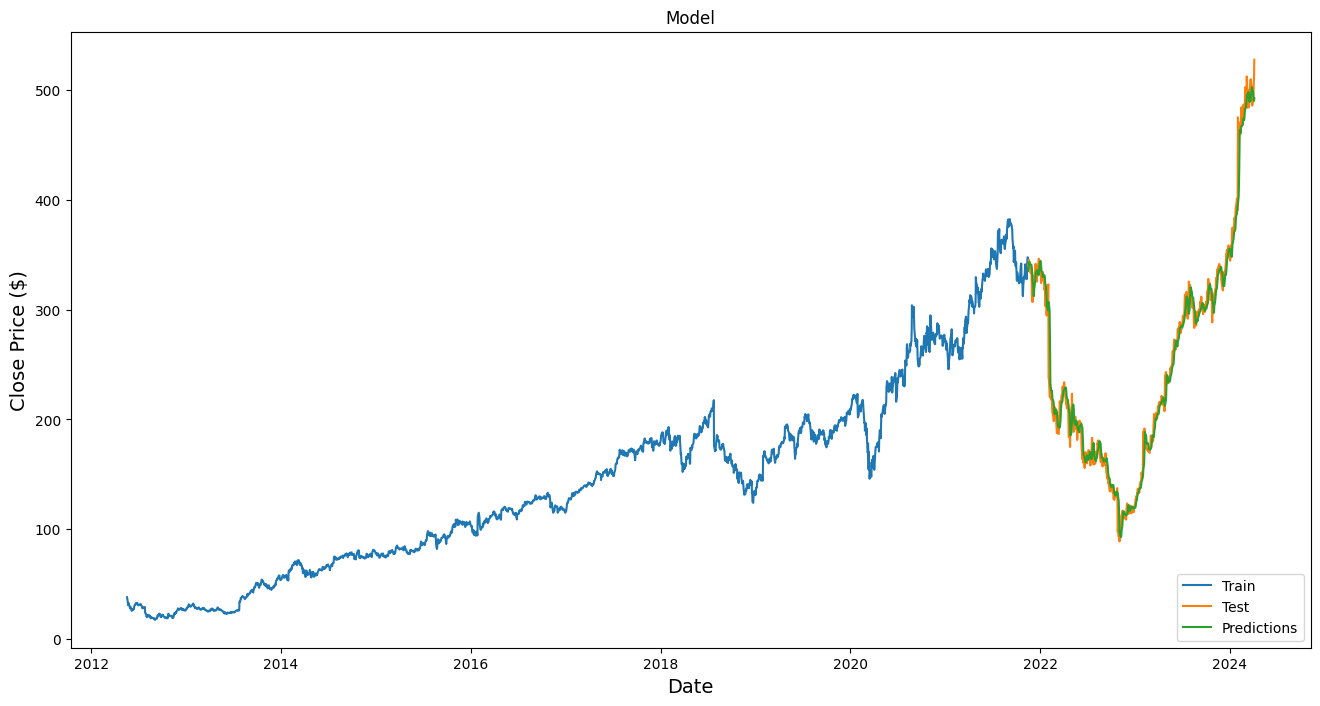

In [25]:
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [26]:
# Show the actual and predicted values of closing prices for the test dataset
test

,Close,Predictions
Date,,
2021-11-17,340.769989,335.014984
2021-11-18,338.690002,338.929138
2021-11-19,345.299988,342.839569
2021-11-22,341.010010,343.310394
2021-11-23,337.250000,341.679260
...,...,...
2024-04-01,491.350006,497.237701
2024-04-02,497.369995,492.490143
2024-04-03,506.739990,489.710785


We also obtain the model's predictions for the entire dataset to compare its performance on the training dataset as well.

In [27]:
x = []
for i in range(lookback, len(scaled_data)):
    x.append(scaled_data[i-lookback:i, 0])
x = np.array(x)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape

(2984, 5, 1)

In [28]:
predictions_all = model.predict(x)
predictions_all = scaler.inverse_transform(predictions_all)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Since the lookback window is 5, the values for first 5 rows of the original data are not predicted. So we add filler values (say, 0) as the predictions for these dates.

This ensures that the shapes of both columns in the dataset are consistent.  

In [29]:
a = np.zeros(lookback)
a = np.reshape(a, (a.shape[0], 1))
predictions_all = np.concatenate((a, predictions_all), axis=0)
data['Predictions'] = predictions_all 

In [30]:
# Show the actual and predicted values of closing price for the entire dataset.
data

,Close,Predictions
Date,,
2012-05-18,38.230000,0.000000
2012-05-21,34.029999,0.000000
2012-05-22,31.000000,0.000000
2012-05-23,32.000000,0.000000
2012-05-24,33.029999,0.000000
...,...,...
2024-04-01,491.350006,497.237701
2024-04-02,497.369995,492.490143
2024-04-03,506.739990,489.710785


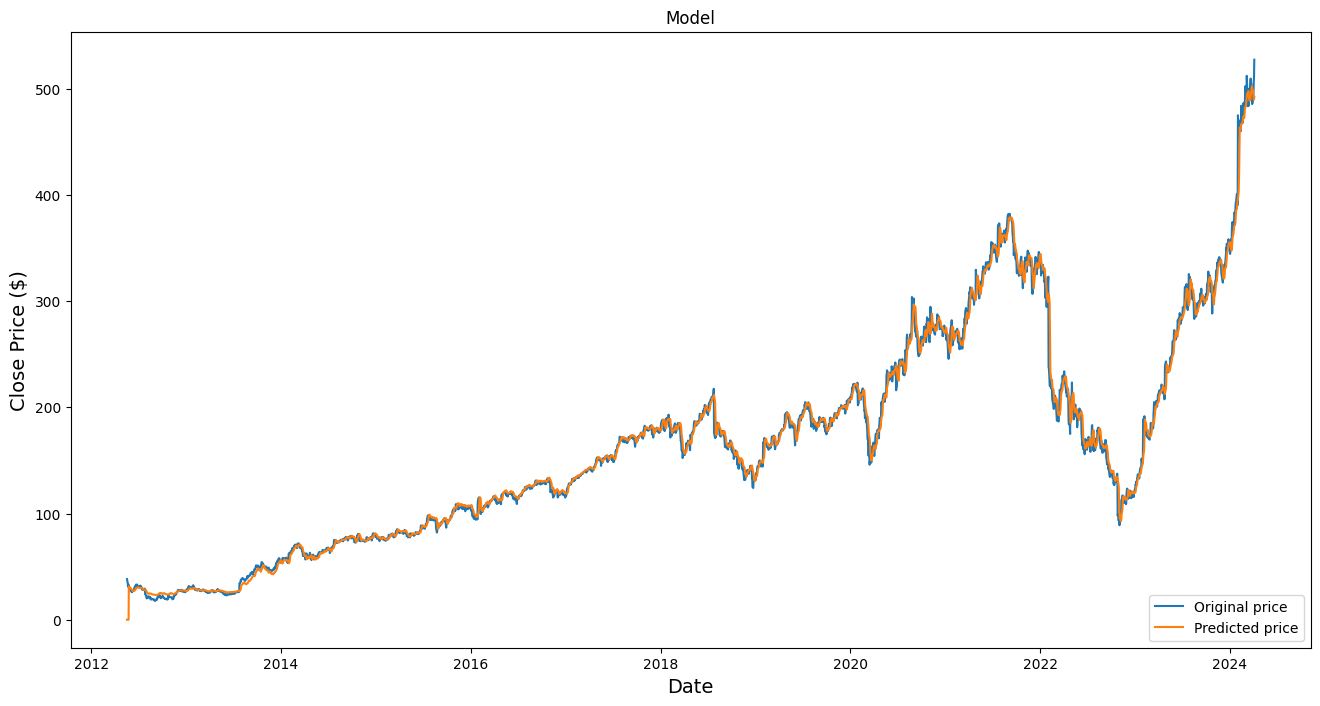

In [31]:
# Plot actual and predicted values over entire dataset.
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price ($)', fontsize=14)
plt.plot(data['Close'])
plt.plot(data['Predictions'])
plt.legend(['Original price', 'Predicted price'], loc='lower right')
plt.show()